You can either download this notebook and run it locally, or you can run it in the cloud:<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="https://colab.research.google.com/github/kirbyju/TCIA_Notebooks/blob/main/TCIA_RTStruct_SEG_Visualization_with_itkWidgets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github.com/kirbyju/TCIA_RTStruct_SEG_Visualization_with_itkWidgets.ipynb)

# Summary
Access to large, high-quality data is essential for researchers to understand disease and precision medicine pathways, especially in cancer. However, HIPAA constraints make sharing medical images outside an individual institution a complex process. [The Cancer Imaging Archive (TCIA)](https://www.cancerimagingarchive.net/) is a public service funded by the National Cancer Institute that addresses this challenge by providing hosting and de-identification services to take major burdens of data sharing off researchers.

## DICOM Image Objects
Most of TCIA data is available as DICOM objects. A wide variety of toolkits are able to read DICOM images, but fewer are able to convert them into volumetric representations, and still fewer correctly maintain the metadata necessary to interpret how that volume maps into physical space (i.e., its origin, axis orientation, and the physical distance between its voxels).  Such information is critical to subsequent analysis of those images.

[ITK](https://github.com/InsightSoftwareConsortium/ITK) is used to read DICOM images.

## DICOM SEG and RTStruct Objects
There are often DICOM SEG (labelmap) and DICOM RTStruct (contour) files that provide annotations for the DICOM images.  Reading and mapping those objects onto medical images, and converting contours to labelmaps and preserving the origin, spacing, and direction information in those labelmaps can also be challenging.

Herein, we explore a common AI research workflow.  We demonstrate basic methods for downloading DICOM objects from TCIA, converting them into images and labelmaps, and visualizing them within this Jupyter Notebook using itkWidgets.   

[RT-Utils](https://github.com/qurit/rt-utils) (built on top of pydicom) is used to convert RTStruct contours to labelmaps.

[pydicom-seg](https://github.com/razorx89/pydicom-seg) (also built on top of pydicom) is used to convert SEG labelmaps to images.

## Visualization
While Jupyter systems (JupyterLab, Jupyter Notebooks, Google Colab, AWS SageMaker, etc.) are outstanding tools for interactive programming and algorithm sharing, the ability to visualize data within them has traditionally be limited to plots and sparse 2D slices - which are insufficient when dealing with 3D clinical data. This limitation is particularly challenging when using cloud-based jupyter systems such as Google Colab and AWS SageMaker. 3D interactive visualization of data when using those cloud systems traditionally requires downloading that data to your local machine and then running a separate visualization application. itkWidgets addresses those visualization challenges by providing interacitve 3D (and 2D) visualizations within the cells of your Jupyter scripts.

[itkWidgets](https://github.com/InsightSoftwareConsortium/itkwidgets) is used to visualize images, point sets, and 3D geometry in Jupyter systems (Jupyter Notebooks, JupyterLab, AWS SageMaker, and Google Colab). Despite its name, itkWidgets does not require the use of ITK. It can directly visualize numpy arrays, torch tensors, DASK arrays, VTK polydata, and a multitude of other Python data structures.

# Outline

1. Setup
2. TCIA Basics
2. itkWidgets Basics
3. Use Cases
    1. Load and visualize DICOM Images and RTStruct objects from TCIA
    2. Load and visualize DICOM Images and SEG objects from TCIA

# 1. Setup

These are the initial steps for running notebooks within various Jupyter environments.

In [1]:
import os
import sys

# Upgrade pip, just in case...
!{sys.executable} -m pip install --upgrade -q pip

In [2]:
# If running on SageMaker or Studio Lab, install essential packages and extensions.
if "studio-lab-user" in os.getcwd():
    print("Upgrading dependencies")
    !conda install --yes -q --prefix {sys.prefix} -c conda-forge opencv nodejs

**On many systems you must manually install the imjoy-jupyter-extension!!**

If you do not see a blue 'ImJoy' icon on the menu bar in this notebook:
   1) Enable Extensions:  Many Jupyter Lab systems disable jupyter extensions by default,
      and they must be enabled for this notebook to work.
      Use the Jupyter interface to select the extension manager (left-hand side, icon that
      looks like a piece of a puzzle) and select the Enable button if it appears.
   2) Install imjoy extension: In the extension manager, search for 'imjoy' and install
      the 'imjoy-jupyter-extension'.
      The installation can take several minutes. It may also prompt you to rebuild, save,
      and reload your jupyter environment as part of this process.  In the end, you should see
      a blue 'ImJoy' icon on the left side of the menu bar in this notebook.

# 2. TCIA Basics

[Browsing Collections](https://www.cancerimagingarchive.net/collections) and viewing [Analysis Results](https://www.cancerimagingarchive.net/tcia-analysis-results/) of datasets on TCIA are the easiest ways to become familiar with what is available.  These pages will help you quickly identify datasets of interest, find valuable supporting data that are not available via our APIs (e.g. clinical spreadsheets, non-DICOM segmentation data), and answer the most common questions you might have about the datasets.  

If you are new to accessing TCIA via notebooks, you can find additional tutorials on querying and downloading data at https://github.com/kirbyju/TCIA_Notebooks.

In [3]:
# Install the common library for TCIA
!{sys.executable} -m pip install --upgrade -q requests
!{sys.executable} -m pip install --upgrade -q pandas

In [4]:
import requests

tcia_utils_text = requests.get("https://github.com/kirbyju/TCIA_Notebooks/raw/main/tcia_utils.py")
with open('tcia_utils.py', 'wb') as f:
    f.write(tcia_utils_text.content)

In [5]:
import tcia_utils as tcia

In [6]:
# Download a "Shared Cart" that has been previously created via the NBIA webset (https://nbia.cancerimagingarchive.net).
cartName = "nbia-49121659384603347"

# retrieve cart metadata
cart_data = tcia.getSharedCart(cartName)

# download the series_uids list and return dataframe of metadata
df = tcia.downloadSeries(cart_data)

# display dataframe
display(df)

Calling...  https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName?name=nbia-49121659384603347
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.2.276.0.7230010.3.1.3.1070885483.15960.1599120307.701
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.144673070302354240405004153445986965004
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.66734119033932110513438442707181367414
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.7311.5101.206828891270520544417996275680
Download Complete: 4 Series Instance UIDs (scans).


,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class UID,Number of Images,File Size,Series Number,License Name,License URL,Annotation Size
0,1.2.276.0.7230010.3.1.3.1070885483.15960.15991...,PROSTATEx,yes,https//doi.org/10.7937/tcia.nbb4-4655,ProstateX-0004,1.3.6.1.4.1.14519.5.2.1.7311.5101.170561193612...,MR prostaat kanker detectie WDSmc MCAPRODETW,10-18-2011,Segmentation,QIICR,SEG,1.2.840.10008.5.1.4.1.1.66.4,1,1450544,300.000000,Creative Commons Attribution 3.0 Unported License,http://creativecommons.org/licenses/by/3.0/,0
1,1.3.6.1.4.1.14519.5.2.1.1446730703023542404050...,Pediatric-CT-SEG,NO,https://doi.org/10.7937/TCIA.X0H0-1706,Pediatric-CT-SEG-00DCF4D6,1.3.6.1.4.1.14519.5.2.1.8859670961354389003042...,CT,10-09-2009,RTSTRUCT,Varian Medical Systems,RTSTRUCT,1.2.840.10008.5.1.4.1.1.481.3,1,15459192,2.000000,Creative Commons Attribution-NonCommercial 4.0...,https://creativecommons.org/licenses/by-nc/4.0/,0
2,1.3.6.1.4.1.14519.5.2.1.6673411903393211051343...,Pediatric-CT-SEG,NO,https://doi.org/10.7937/TCIA.X0H0-1706,Pediatric-CT-SEG-00DCF4D6,1.3.6.1.4.1.14519.5.2.1.8859670961354389003042...,CT,10-09-2009,CT,GE MEDICAL SYSTEMS,CT,1.2.840.10008.5.1.4.1.1.2,207,109041294,30144.000000,Creative Commons Attribution-NonCommercial 4.0...,https://creativecommons.org/licenses/by-nc/4.0/,0
3,1.3.6.1.4.1.14519.5.2.1.7311.5101.206828891270...,PROSTATEx,NaN,https://doi.org/10.7937/K9TCIA.2017.MURS5CL,ProstateX-0004,1.3.6.1.4.1.14519.5.2.1.7311.5101.170561193612...,MR prostaat kanker detectie WDSmc MCAPRODETW,10-18-2011,t2tsetra,SIEMENS,MR,1.2.840.10008.5.1.4.1.1.4,19,5679226,5.000000,Creative Commons Attribution 3.0 Unported License,http://creativecommons.org/licenses/by/3.0/,0


In [7]:
# For this demo...

# Install itk for DICOM I/O and for reading DICOM into an itkImage 
#   that manages all DICOM field values, include acquistion details 
#   such as voxel image, image orientation, and image directions,
#   which are critical to image processing and display
!{sys.executable} -m pip install --upgrade --pre -q "itk==5.3rc4.post3"

# Install rt-utils for reading DICOM RT-Struct objects.
!{sys.executable} -m pip install --upgrade -q rt-utils

# Install pydicom-seg for reading DICOM SEG objects.
!{sys.executable} -m pip install --upgrade -q pydicom-seg

In [8]:
import glob

# Include ITK for DICOM reading.
import itk

# Include numpy which is used by pydicom-seg and rt_utils.
import numpy as np

# Pydicom-Seg is a layer on top of pydicom that handles DICOM SEG objects.
import pydicom
import pydicom_seg

# RT-Utils is a layer on top of pydicom that provides a convenient way to read RT-STRUCT DICOM contours and
#   generate labelmaps from them.  Labelmaps are needed for most deep learning segmentation tasks.
from rt_utils import RTStructBuilder

# 3. itkWidget Basics

[itkWidgets documentation](https://itkwidgets.readthedocs.io/en/latest/?badge=latest) provides a summary and illustrations of itkWidgets for a wide variety of scientific data visualization use cases.  Here we focus on its application to data on TCIA.

In [9]:
# This is the installation required for itkWidgets.
!{sys.executable} -m pip install --upgrade --pre -q "itkwidgets[all]==1.0a20" imjoy_elfinder

In [10]:
# This is the most common import command for itkWidgets.
#   The view() function opens an interactive viewer for 2D and 3D
#   data in a variety of formats.
from itkwidgets import view

# 4. Use cases
In this section, we'll download a few datasets from TCIA to show off the functionality of ITK and itkWidgets by demonstrating the following use cases:

3.A. Load and visualize DICOM Image and RTStruct objects from TCIA.<br>
3.B. Load and visualize DICOM Image and SEG objects from TCIA.<br>

## 4.A. Load and visualize DICOM Image and RTStruct objects from TCIA

### 4.A.1. Identify CT and RTSTRUCT data from the Pediatric-CT-SEG study

In [11]:
dicom_data_dir = "tciaDownload"

# The Pediatric-CT-SEG study provides DICOM images and DICOM RTSTRUCT data.
ped_study_df = df.query( 'Collection=="Pediatric-CT-SEG"')

# The series_uid defines their directory where the CT data was stored on disk.
ped_ct_series_uid = ped_study_df.at[df.Modality.eq('CT').idxmax(), 'Series UID']
ped_ct_dir = os.path.join(dicom_data_dir, ped_ct_series_uid)

# The series_uid defines where the RTSTRUCT was stored on disk.  It is stored in a single file.
ped_rtstruct_series_uid = ped_study_df.at[df.Modality.eq('RTSTRUCT').idxmax(), 'Series UID']
ped_rtstruct_dir = os.path.join(dicom_data_dir, ped_rtstruct_series_uid)
ped_rtstruct_file = seg_file = glob.glob(os.path.join(ped_rtstruct_dir, "*.dcm"))[0]

### 4.A.2. Read and visualize CT and RTSTRUCT data from the Pediatric-CT-SEG study

In [12]:
# Read the DICOM CT series' objects and reconstruct them into a 3D ITK image.
#   The itk.F option is added to store the image in memory using floating-point precision pixels (useful if you will filter the image or use it with MONAI)
#   For more info on imread, see https://itkpythonpackage.readthedocs.io/en/master/Quick_start_guide.html. 
ped_ct_image_large = itk.imread(ped_ct_dir, itk.F)

# We use RT-Utils to read in the list of contours (ROIs) available in the RT-STRUCT file.  This also requires passing-in the path to the original
#   DICOM series (image) so that labelmaps images can be generated from the RT-STRUCT contours.
ped_rtstruct = RTStructBuilder.create_from(dicom_series_path=ped_ct_dir, rt_struct_path=ped_rtstruct_file)

# RT-Utils has many useful functions, including the ability to list the names of the ROIs available in the RT-STRUCT file.
print(ped_rtstruct.get_roi_names())

['Bones', 'Skin', 'Lung_R', 'UteroCervix', 'Thymus', 'Stomach', 'Spleen', 'Spinal Canal', 'Small Intestine', 'Rectum', 'Prostate', 'Pancreas', 'Liver', 'Large Intestine', 'Kidney Right', 'Kidney Left', 'Heart', 'Gonads', 'Gall Bladder', 'Femoral Head Rig', 'Femoral Head Lef', 'Esophagus', 'Duodenum', 'Breast Right', 'Breast Left', 'Bladder', 'Adrenal Right', 'Adrenal Left', 'Lung_L']


In [13]:
# Read in the bones contour as a numpy array.  We must also convert it to float (for possible future filtering, MONAI, etc.), and realign the axis to 
#   correspond with how images are stored by ITK.  This realignment typically isn't needed, but rt-utils requires it.
#   Note: The copy() call is required to force the transpose to actually reorder the data in memory versus maintain an abstraction.
ped_bones_array = ped_rtstruct.get_roi_mask_by_name("Bones").astype(np.float32).transpose(2,0,1).copy()
# As an np array, the rtstruct labelmap is missing critical information about pixel spacing, image origin, image orientation, etc.
#    Here we create an itk image from the numpy array, and we copy the critical information from itk image created from the 
#    original DICOM CT data.
ped_bones_labelmap_large = itk.GetImageFromArray(ped_bones_array)
ped_bones_labelmap_large.CopyInformation(ped_ct_image_large)

In [14]:
# This data is huge, so to save time during demos, we subsample it in x and y dims:
new_spacing = list(ped_ct_image_large.GetSpacing())
new_spacing[:2] = [x*4 for x in new_spacing[:2]]
new_size = list(ped_ct_image_large.GetLargestPossibleRegion().GetSize())
new_size[:2] = [x//4 for x in new_size[:2]]
ped_ct_image = itk.resample_image_filter(Input=ped_ct_image_large,
                                         output_spacing=new_spacing, 
                                         output_origin=ped_ct_image_large.GetOrigin(), 
                                         output_direction=ped_ct_image_large.GetDirection(),
                                         size=new_size)
labelmap_interpolator = itk.NearestNeighborInterpolateImageFunction.New(InputImage=ped_bones_labelmap_large)
ped_bones_labelmap = itk.resample_image_filter(Input=ped_bones_labelmap_large,
                                         Interpolator=labelmap_interpolator,
                                         ReferenceImage=ped_ct_image,
                                         UseReferenceImage=True)
print(f"New spacing = {new_spacing}")
print(f"New size = {new_size}")

New spacing = [2.343752, 2.343752, 2.0]
New size = [128, 128, 207]


In [15]:
# This generates a default 3D visualization, with the bone labelmap coloring the bones "red." 

viewerA = view(image=ped_ct_image, label_image=ped_bones_labelmap)

# Please be patient..this is a huge dataset and it loads slowly when run on Colab or Sagemaker.   Those systems limit data transfer rates 
#   and packet sizes, so itkWidgets must create an multi-scale image and transfer it via incremental streaming.
# Visualization should be fast when run using local resources.

<IPython.core.display.Javascript object>

In [16]:
# Here we demonstrate how to programmatically set some of the common volume rendering options.
viewerA.set_background_color([0.1,0.1,0.1])
viewerA.set_image_color_map("CT-Muscle")
viewerA.set_image_gradient_opacity(0.45)
viewerA.set_image_gradient_opacity_scale(0.35)
viewerA.set_image_color_range([-1000,1000])

In [17]:
# In case you haven't seen it, here we open the user interface panel so that you can manually manipulate the visualization.
viewerA.set_ui_collapsed(False)

# For example, clicking on the colored cubes in the second row in this panel will switch to a 2D view with the labelmap overlaid.

## 4.B. Load and visualizing DICOM image and SEG objects from TCIA

### 4.B.1. Identify MR and SEG data from the PROSTATEx study

In [18]:
# The PROSTATEx study provides DICOM images and DICOM SEG data.
pro_study_df = df.query( 'Collection=="PROSTATEx"' )

# The series_uid defines their directory where the MR data was stored on disk.
pro_mr_series_uid = pro_study_df.at[df.Modality.eq('MR').idxmax(), 'Series UID']
pro_mr_dir = os.path.join(dicom_data_dir, pro_mr_series_uid)

# The series_uid defines where the RTSTRUCT was stored on disk.  It is stored in a single file.
pro_seg_series_uid = pro_study_df.at[df.Modality.eq('SEG').idxmax(), 'Series UID']
pro_seg_dir = os.path.join(dicom_data_dir, pro_seg_series_uid) 
pro_seg_file = glob.glob(os.path.join(pro_seg_dir, "*.dcm"))[0]

### 4.B.2. Read MR and SEG data and restore SEG data's physical info

In [19]:
# Read the DICOM MR series' objects and reconstruct them into a 3D ITK image.
#   The itk.F option is added to store the image in memory using floating-point precision pixels (useful if you will filter the image or use it with MONAI)
#   For more info on imread, see https://itkpythonpackage.readthedocs.io/en/master/Quick_start_guide.html 
pro_mr_image = itk.imread(pro_mr_dir, itk.F)

# Read the DICOM SEG object using pydicom and pydicom_seg.
pro_seg_dicom = pydicom.dcmread(pro_seg_file)
seg_reader = pydicom_seg.MultiClassReader()
pro_seg_obj = seg_reader.read(pro_seg_dicom)

# Convert the DICOM SEG object into an itk image, with correct voxel origin, spacing, and directions in physical space.
pro_seg_image = itk.GetImageFromArray(pro_seg_obj.data.astype(np.float32))
pro_seg_image.SetOrigin(pro_seg_obj.origin)
pro_seg_image.SetSpacing(pro_seg_obj.spacing)
pro_seg_image.SetDirection(pro_seg_obj.direction)

### 4.B.3. Visualize MRI with SEG data overlaid, as slice data


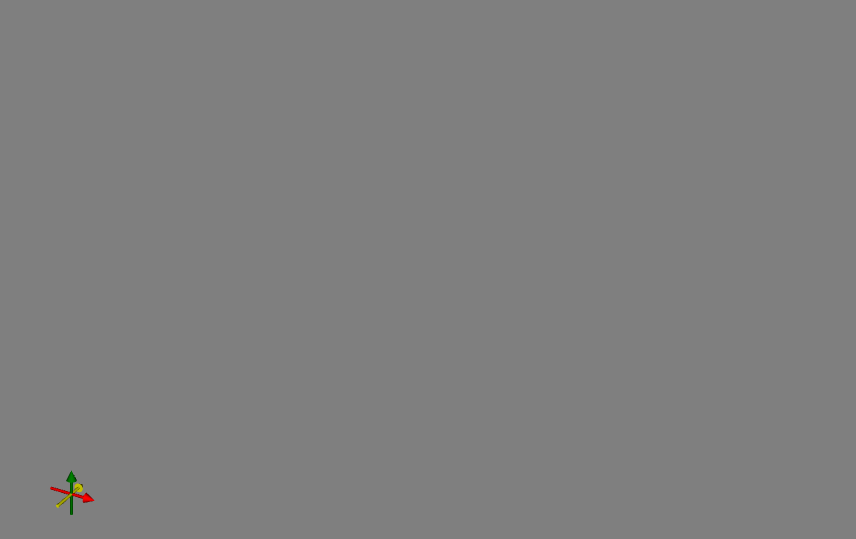
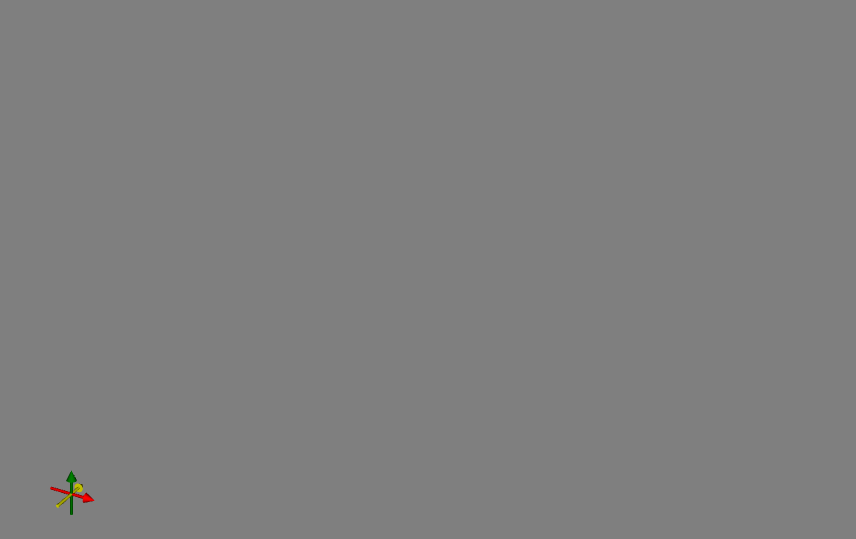

<IPython.core.display.Javascript object>

In [20]:
viewerB = view(image=pro_mr_image, 
               label_image=pro_seg_image)

In [21]:
viewerB.set_image_color_map("Grayscale")
viewerB.set_image_color_range([0,400])
viewerB.set_view_mode("ZPlane")
viewerB.set_z_slice(53)
viewerB.set_ui_collapsed(False)

# Acknowledgements

TCIA is funded by the [Cancer Imaging Program (CIP)](https://imaging.cancer.gov/), a part of the United States [National Cancer Institute (NCI)](https://www.cancer.gov/), and is managed by the [Frederick National Laboratory for Cancer Research (FNLCR)](https://frederick.cancer.gov/).

If you leverage this notebook or any TCIA datasets in your work, please be sure to comply with the [TCIA Data Usage Policy](https://wiki.cancerimagingarchive.net/x/c4hF). In particular, make sure to cite the DOI(s) for the specific TCIA datasets you used in addition to TCIA citation provided below!

This notebook was created by [Stephen Aylward (Kitware)](https://www.kitware.com/stephen-aylward/), [Justin Kirby (Frederick National Laboratory for Cancer Research)](https://www.linkedin.com/in/justinkirby82/), [Brianna Major (Kitware)](https://www.kitware.com/brianna-major/), and [Matt McCormick (Kitware)](https://www.kitware.com/matt-mccormick/).   The creation of this notebook was funded, in part, by NIBIB and NIGMS R01EB021396, NIBIB R01EB014955, NCI R01CA220681, and NINDS R42NS086295.

If you have any questions, suggestions, or issues with itkWidgets, please post them on the [itkwidget issue tracker](https://github.com/InsightSoftwareConsortium/itkwidgets/issues) or feel free to email us at kitware@kitware.com.

## Data Citation
Some of the data used in this notebook was part of the Pediatric-CT-SEG collection:

Jordan, P., Adamson, P. M., Bhattbhatt, V., Beriwal, S., Shen, S., Radermecker, O., Bose, S., Strain, L. S., Offe, M., Fraley, D., Principi, S., Ye, D. H., Wang, A. S., Van Heteren, J., Vo, N.-J., & Schmidt, T. G. (2021). Pediatric Chest/Abdomen/Pelvic CT Exams with Expert Organ Contours (Pediatric-CT-SEG) (Version 2) [Data set]. The Cancer Imaging Archive. https://doi.org/10.7937/TCIA.X0H0-1706

Some of the data used in this notebook was part of the ProstateX challenge:

Geert Litjens, Oscar Debats, Jelle Barentsz, Nico Karssemeijer, and Henkjan Huisman. "ProstateX Challenge data", The Cancer Imaging Archive (2017). DOI: 10.7937/K9TCIA.2017.MURS5CL

## Publication Citation
Some of the data used in this notebook was part of the Pediatric-CT-SEG collection:

Jordan, P., Adamson, P. M., Bhattbhatt, V., Beriwal, S., Shen, S., Radermecker, O., Bose, S., Strain, L. S., Offe, M., Fraley, D., Principi, S., Ye, D. H., Wang, A. S., Heteren, J., Vo, N., & Schmidt, T. G. (2022). Pediatric chest‐abdomen‐pelvis and abdomen‐pelvis CT images with expert organ contours. In Medical Physics (Vol. 49, Issue 5, pp. 3523–3528). Wiley. https://doi.org/10.1002/mp.15485

Some of the data used in this notebook was part of the ProstateX challenge:

Litjens G, Debats O, Barentsz J, Karssemeijer N, Huisman H. "Computer-aided detection of prostate cancer in MRI", IEEE Transactions on Medical Imaging 2014;33:1083-1092. DOI: 10.1109/TMI.2014.2303821

## TCIA Citation

Clark, K., Vendt, B., Smith, K., Freymann, J., Kirby, J., Koppel, P., Moore, S., Phillips, S., Maffitt, D., Pringle, M., Tarbox, L., & Prior, F. (2013). The Cancer Imaging Archive (TCIA): Maintaining and Operating a Public Information Repository. Journal of Digital Imaging, 26(6), 1045–1057. https://doi.org/10.1007/s10278-013-9622-7